In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
from ImageGenerator import ImageAugmentation

In [2]:
def load_image(image_path, expression_index, gender_label):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255
    label = [expression_index, 0 if gender_label == 'male' else 1]
    return img, label

def load_expression_data(directory, expression_index, expression_label):
    images = []
    labels = []
    for gender_label in os.listdir(os.path.join(directory, expression_label)):
        image_dir = os.path.join(directory, expression_label, gender_label)
        image_paths = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
        for image_path in image_paths:
            image, label = load_image(image_path, expression_index, gender_label)
            images.append(image)
            labels.append(label)
    return images, labels

def load_data(directory, max_workers=7):
    expressions = os.listdir(directory)
    all_images = []
    all_labels = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = executor.map(load_expression_data, [directory]*len(expressions), range(len(expressions)), expressions)
        for images, labels in results:
            all_images.extend(images)
            all_labels.extend(labels)
    all_labels = np.array(all_labels)
    expression_labels = tf.keras.utils.to_categorical(all_labels[:, 0], num_classes=len(expressions))
    all_labels = np.hstack((expression_labels, all_labels[:, 1].reshape(-1, 1)))
    return np.vstack(all_images), all_labels

In [3]:
images, labels = load_data('data/face_expression_gender')
images.shape, labels.shape

((33619, 48, 48, 1), (33619, 8))

In [4]:
label_dict = {
    (1, 0, 0, 0, 0, 0, 0, 0) : 'angry male',
    (1, 0, 0, 0, 0, 0, 0, 1) : 'angry female',
    (0, 1, 0, 0, 0, 0, 0, 0) : 'disgust male',
    (0, 1, 0, 0, 0, 0, 0, 1) : 'disgust female',
    (0, 0, 1, 0, 0, 0, 0, 0) : 'fear male',
    (0, 0, 1, 0, 0, 0, 0, 1) : 'fear female',
    (0, 0, 0, 1, 0, 0, 0, 0) : 'happy male',
    (0, 0, 0, 1, 0, 0, 0, 1) : 'happy female',
    (0, 0, 0, 0, 1, 0, 0, 0) : 'neutral male',
    (0, 0, 0, 0, 1, 0, 0, 1) : 'neutral female',
    (0, 0, 0, 0, 0, 1, 0, 0) : 'sad male',
    (0, 0, 0, 0, 0, 1, 0, 1) : 'sad female',
    (0, 0, 0, 0, 0, 0, 1, 0) : 'surprise male',
    (0, 0, 0, 0, 0, 0, 1, 1) : 'surprise female',
}

In [5]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
        print(label_dict[tuple(label)], counts[i])
    plt.bar(range(len(unique_labels)), counts)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Label Distribution')
    plt.xticks(range(len(unique_labels)), [label_dict[tuple(label)] for label in unique_labels], rotation=90)
    plt.show()

surprise male 1665.0
surprise female 1912.0
sad male 2883.0
sad female 2874.0
neutral male 3500.0
neutral female 2168.0
happy male 2981.0
happy female 5410.0
fear male 2136.0
fear female 2829.0
disgust male 261.0
disgust female 262.0
angry male 3089.0
angry female 1649.0


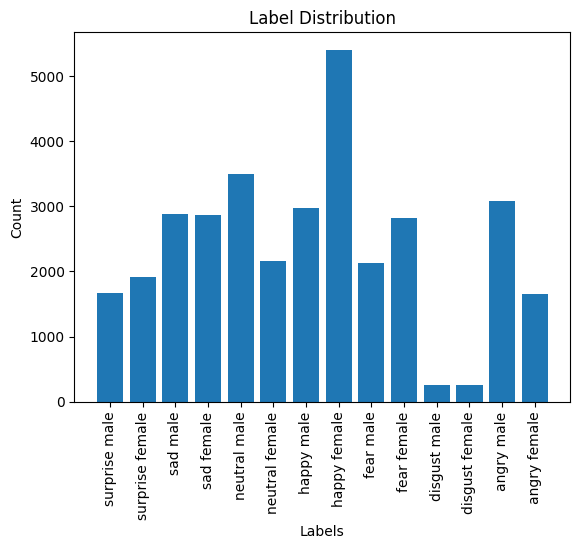

In [6]:
plot_label_distribution(labels)

In [7]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index], cmap='gray')
        axes[i].set_title(label_dict[tuple(labels[index])])
        axes[i].axis('off')
    plt.show()

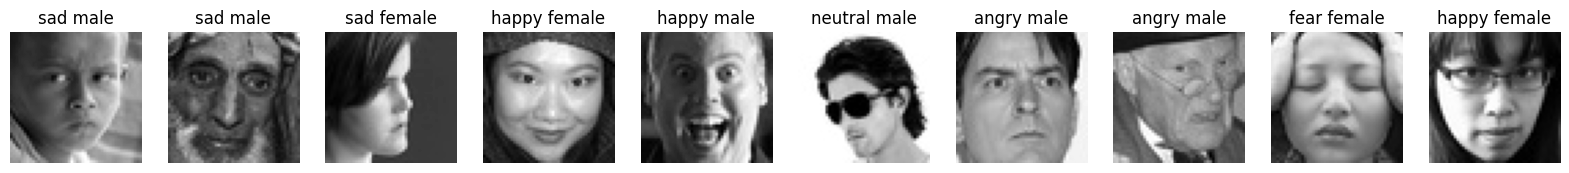

In [8]:
show_sample_images(images, labels)

In [9]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

surprise male 1665.0
surprise female 1912.0
sad male 2000.0
sad female 2000.0
neutral male 2000.0
neutral female 2000.0
happy male 2000.0
happy female 2000.0
fear male 2000.0
fear female 2000.0
disgust male 261.0
disgust female 262.0
angry male 2000.0
angry female 1649.0


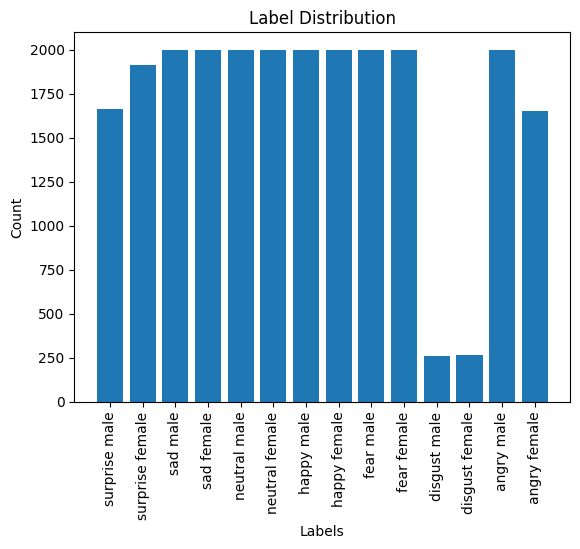

In [10]:
downsampled_images, downsampled_labels = downsample(images, labels, n_samples=2000)
plot_label_distribution(downsampled_labels)

In [11]:
augmentator = ImageAugmentation(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [12]:
def image_augmentation(images, labels, target_label, num_augmentations=5):
    augmented_images = []
    augmented_labels = []
    augmented_images.extend(images)
    augmented_labels.extend(labels)
    target_indices = [i for i, label in enumerate(map(tuple, labels)) if label == target_label]
    target_images = [images[i] for i in target_indices]
    target_labels = [labels[i] for i in target_indices]
    images_temp, labels_temp = augmentator.flow(images=target_images, labels=target_labels, num_augmentations=num_augmentations, shuffle=True)
    show_sample_images(images_temp, labels_temp, num_images=10)
    augmented_images.extend(images_temp)
    augmented_labels.extend(labels_temp)
    return np.array(augmented_images), np.array(augmented_labels)


Generated 1566 augmented images.


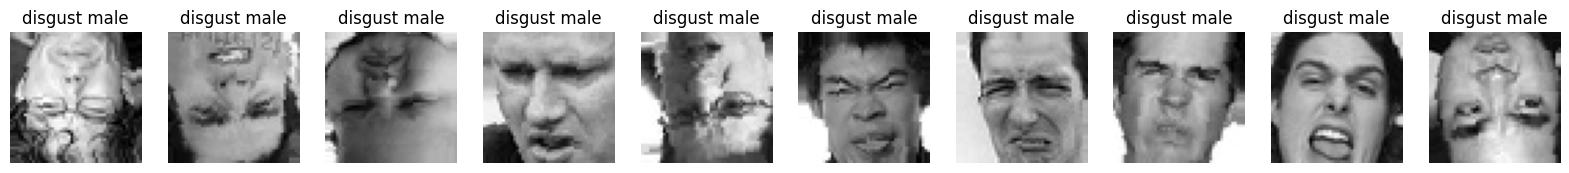

Generated 1572 augmented images.


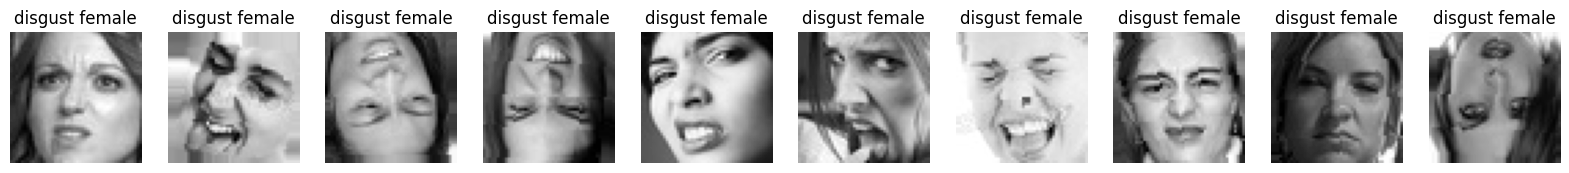

In [13]:
augmented_images, augmented_labels = image_augmentation(downsampled_images, downsampled_labels, (0, 1, 0, 0, 0, 0, 0, 0), num_augmentations=5)
augmented_images, augmented_labels = image_augmentation(augmented_images, augmented_labels, (0, 1, 0, 0, 0, 0, 0, 1), num_augmentations=5)

surprise male 1665.0
surprise female 1912.0
sad male 2000.0
sad female 2000.0
neutral male 2000.0
neutral female 2000.0
happy male 2000.0
happy female 2000.0
fear male 2000.0
fear female 2000.0
disgust male 1827.0
disgust female 1834.0
angry male 2000.0
angry female 1649.0


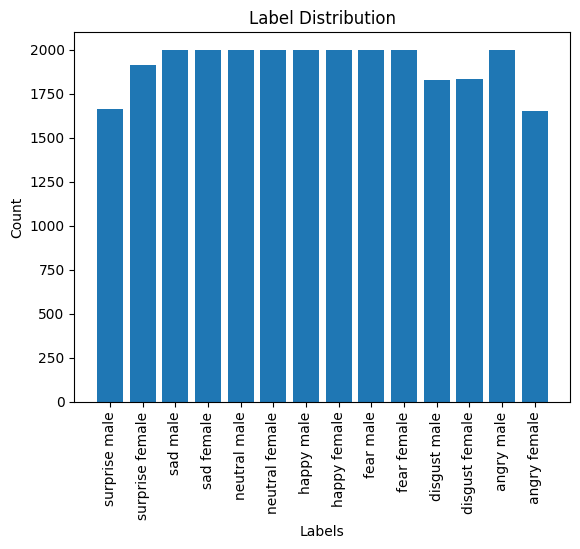

In [14]:
plot_label_distribution(augmented_labels)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((21509, 48, 48, 1), (5378, 48, 48, 1), (21509, 8), (5378, 8))

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
673/673 [==============================] - 8s 11ms/step - loss: 0.4158 - accuracy: 0.0961 - val_loss: 0.3789 - val_accuracy: 0.1880
Epoch 2/10
673/673 [==============================] - 7s 11ms/step - loss: 0.3477 - accuracy: 0.2254 - val_loss: 0.3606 - val_accuracy: 0.2510
Epoch 3/10
673/673 [==============================] - 6s 9ms/step - loss: 0.3063 - accuracy: 0.3092 - val_loss: 0.3553 - val_accuracy: 0.2469
Epoch 4/10
673/673 [==============================] - 6s 9ms/step - loss: 0.2658 - accuracy: 0.3817 - val_loss: 0.3658 - val_accuracy: 0.2562
Epoch 5/10
673/673 [==============================] - 7s 10ms/step - loss: 0.2244 - accuracy: 0.4506 - val_loss: 0.3784 - val_accuracy: 0.2919
Epoch 6/10
673/673 [==============================] - 7s 10ms/step - loss: 0.1816 - accuracy: 0.5182 - val_loss: 0.4018 - val_accuracy: 0.3051
Epoch 7/10
673/673 [==============================] - 7s 10ms/step - loss: 0.1419 - accuracy: 0.5772 - val_loss: 0.4544 - val_accuracy: 0.3265
E

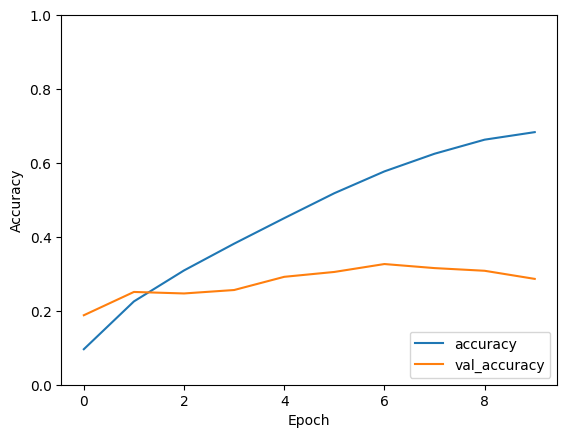

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch') 
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [29]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.round(y_pred)
    

169/169 [==============================] - 0s 2ms/step


In [30]:
print(y_test.shape, y_pred.shape)

(5378, 8) (5378, 8)


In [31]:
y_test_decoded = []
y_pred_decoded = []

for i in range(len(y_test)):
    y_test_key = tuple(y_test[i])
    y_pred_key = tuple(y_pred[i])        
    if y_pred_key in label_dict:
        y_pred_decoded.append(label_dict[y_pred_key])
    else:
        y_pred_decoded.append('Unknown label')

In [32]:
classes, _ = np.unique(y_pred_decoded, return_inverse=True)
print(classes) 

['Unknown label' 'angry female' 'angry male' 'disgust female'
 'disgust male' 'fear female' 'fear male' 'happy female' 'happy male'
 'neutral female' 'neutral male' 'sad female' 'sad male' 'surprise female'
 'surprise male']


In [33]:
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test_decoded, y_pred_decoded), annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(ticks=np.arange(len(classes))+0.5, labels=classes, rotation=30)
plt.yticks(ticks=np.arange(len(classes))+0.5, labels=classes, rotation=30)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [0, 5378]

<Figure size 1000x1000 with 0 Axes>